## Subset sampling for GHZ state preparation circuit

**1. Direct Monte Carlo approach**

CPU times: user 3.72 s, sys: 34.8 ms, total: 3.75 s
Wall time: 3.69 s


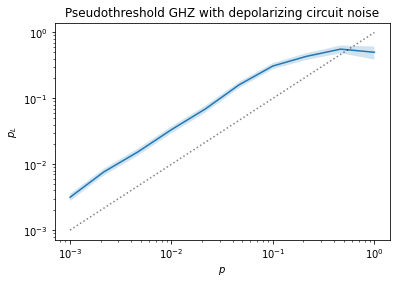

In [12]:
%%time

import pecos as pc
import numpy as np
import matplotlib.pyplot as plt

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))
depolar_gen = pc.error_gens.DepolarGen(model_level='circuit')

p_phy = np.logspace(-3, 0, 10) # evenly spaced samples in log space
n_samples = 20
sample_range = np.int_(n_samples / p_phy) # take more samples for lower p_phy

def MC(p, n_samples):
    logical_errs = 0
    for _ in range(n_samples):
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, ghz, error_gen=depolar_gen, error_params={'p':p})
        if msmt: 
            logical_errs += 1
    return logical_errs

p_L= np.empty_like(p_phy)
for i, p in enumerate(p_phy):
    n_fails = MC(p, sample_range[i])
    p_L[i] = n_fails / sample_range[i]

p_L_err = np.sqrt(p_L*(1-p_L)/sample_range)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
plt.plot(p_phy, p_L)
plt.fill_between(p_phy, p_L-p_L_err, p_L+p_L_err, alpha=0.2)
plt.plot(p_phy, p_phy, 'k:', alpha=0.5)

**2. Subset sampling approach**

CPU times: user 37.3 ms, sys: 4.23 ms, total: 41.6 ms
Wall time: 34.2 ms


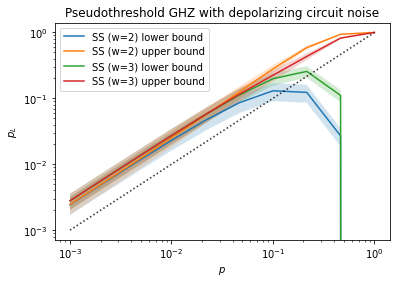

In [14]:
%%time

import itertools
import math
import pecos as pc
import numpy as np
import matplotlib.pyplot as plt

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(itertools.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

def subset_sample(ref_circuit, subset_weight, n_samples):
    logical_fails = 0
    for _ in range(n_samples):
        
        # 1. Generate a subset circuit, place random faults at w gates
        subset_circuit = ref_circuit.copy()
        fault_locs = np.random.choice(len(subset_circuit), subset_weight, replace=False)
        for loc in fault_locs:
            for sym, qbs, params in subset_circuit[loc].items():
                if sym in two_qb_gates: 
                    faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                    for fault, qb in zip(faults, list(*qbs)):
                        if fault != "I": 
                            subset_circuit.insert(loc, ({fault: {qb}}, {}))
                elif sym in one_qb_gates: 
                    fault = np.random.choice(one_qb_errs)
                    subset_circuit.insert(loc, ({fault: qbs}, {}))
                    
        # 2. Simuluate a circuit run with |00..0> and measure in Z
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, subset_circuit)
        
        # 3.Count logical failures
        if msmt: logical_fails += 1
        
    return logical_fails

n_samples = 20 # number of samples per subset
p_phy = np.logspace(-3, 0, 10) # physical error rates
n_gates = len(ghz) # number of gates in reference circuit

def gen_p_L(w_max):
    # Subset logical failure rates
    p_L_w = np.array([0] + [subset_sample(ghz,w,n_samples)/n_samples for w in range(1,w_max)])

    # Binomial weight: Tot. probability of sampling weight-w circuits from all possible circuits
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    A = np.array([[A_w(p,w,n_gates) for p in p_phy] for w in range(w_max)])

    # Overall bounded logical failure rates
    p_L_low = np.sum(A * p_L_w[:,None], axis=0)
    p_L_up = p_L_low + 1 - np.sum(A, axis=0)

    # Subset and overall standard deviations
    e_SS_w = lambda p, n: np.sqrt( (p * (1-p)) / n )
    e_SS = np.sqrt( np.sum((A[1:] * e_SS_w(p_L_w[1:,None], n_samples))**2, axis=0) )
    return p_L_low, p_L_up, e_SS

w_max = [2,3] # gate fault cutoff
for w_m in w_max:
    p_L_low, p_L_up, e_SS = gen_p_L(w_m)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$p$')
    plt.ylabel(r'$p_L$')
    plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
    plt.plot(p_phy, p_L_low, label="SS (w=%s) lower bound" % w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, alpha=0.2)
    plt.plot(p_phy, p_L_up, label="SS (w=%s) upper bound" % w_m)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, alpha=0.2)
    plt.plot(p_phy, p_phy, 'k:', alpha=0.5)
plt.legend()

**3. Comparison plot**

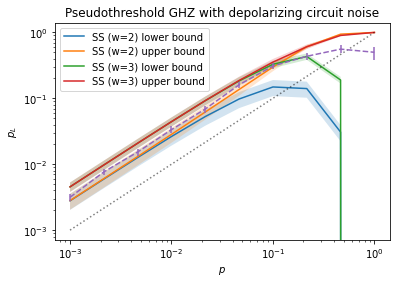

In [32]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')

for marker, w_m in zip(['-', '-'],[2,3]):
    p_L_low, p_L_up, e_SS = gen_p_L(w_m)
    plt.plot(p_phy, p_L_low, marker, label="SS (w=%s) lower bound"%w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, alpha=0.2)
    plt.plot(p_phy, p_L_up, marker, label="SS (w=%s) upper bound"%w_m)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, alpha=0.2)

plt.errorbar(p_phy, p_L, fmt='--', yerr=p_L_err)
plt.plot(p_phy, p_phy, 'k:', alpha=0.5)
plt.legend()